In [12]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
train = pd.read_csv('train_data_regression_model')
train = train.iloc[:,1:]
train = train.rename(columns={"1stD": "First_Downs", "Att.1": "Att_First", "Y/P":"YpP", "Y/A":"YpA", "Rush_1stD":"Rush_Firsts", "TO%":"TOPerc"})
train

test = pd.read_csv('Test Data')
test = test.iloc[:,1:]
test = test.rename(columns={"1stD": "First_Downs", "Att.1": "Att_First", "Y/P":"YpP", "Y/A":"YpA", "Rush_1stD":"Rush_Firsts", "TO%":"TOPerc"})
test = test.drop(columns = ['Rk','G'])

actual_wins = pd.read_csv('Actual Wins')
actual_wins = actual_wins.iloc[:,1:]
actual_wins
test = pd.merge(test,actual_wins)
train = train.drop(columns = ['Rk','G'])


In [31]:
# Naive Model
ols_object = smf.ols(formula = 'W~Yds+TO+FL+Cmp+Att+Pass_Yds+TD+Int+Rush_Yds+Rush_TD+Pen+Pen_Yds+First_Downs+Att_First+YpP+YpA+Rush_Firsts+TOPerc+Ply', data = train)
naive_model = ols_object.fit()
naive_model.summary()

# Insights: Yds not significant but touchdowns (obviously) are. Turnovers significant, but for some reason fumbles lost are not.
# Explore that by using interadtion Term. Completions and Attempts not significant. Even though yds not significant, the coefficient is 
# negative, surprisingly. Use only significant predictors for next iteration.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     22.68
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           2.83e-32
Time:                        15:26:50   Log-Likelihood:                -303.40
No. Observations:                 160   AIC:                             642.8
Df Residuals:                     142   BIC:                             698.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      28.9447     23.071      1.255      0.212     -16.662      74.551
Yds             0.0017      0.003      0.556      0.579      -0.004       0.008
TO              0.1950      0.090      2.168      0.032       0.017       0.373
FL              0.0900      0.051      1.766      0.080      -0.011       0.191
Cmp             0.0230      0.010      2.207      0.029       0.002       0.044
Att             0.0337      0.017      1.995      0.048       0.000       0.067
Pass_Yds        0.0014      0.002      0.626      0.532      -0.003       0.006
TD              0.1197      0.037      3.278      0.001       0.047       0.192
Int             0.1049      0.059      1.787      0.076      -0.011       0.221
Rush_Yds        0.0004      0.004      0.102      0.919      -0.007       0.008
Rush_TD         0.1128      0.055      2.066      0.041       0.005       0.221
Pen             0.0281      0.024      1.188      0.237      -0.019       0.075
Pen_Yds        -0.0010      0.002     -0.412      0.681      -0.006       0.004
First_Downs     0.0380      0.016      2.421      0.017       0.007       0.069
Att_First       0.0790      0.028      2.780      0.006       0.023       0.135
YpP            -4.5425      3.878     -1.171      0.243     -12.208       3.123
YpA            -0.3244      2.155     -0.151      0.881      -4.585       3.936
Rush_Firsts    -0.0237      0.021     -1.151      0.252      -0.064       0.017
TOPerc         -0.8621      0.264     -3.263      0.001      -1.384      -0.340
Ply            -0.0823      0.025     -3.339      0.001      -0.131      -0.034
==============================================================================
Omnibus:                        2.391   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.303   Jarque-Bera (JB):                2.410
Skew:                          -0.255   Prob(JB):                        0.300
Kurtosis:                       2.683   Cond. No.                     6.41e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.05e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [138]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

# Ridge Regression - will not transform wins as it is not right skewed
y = train.W
X = train.iloc[:,2:]
scaler = StandardScaler()
scaler.fit(X)
Xstd = scaler.transform(X)
X.columns

Index(['PF', 'Yds', 'Ply', 'YpP', 'TO', 'FL', 'First_Downs', 'Cmp', 'Att',
       'Pass_Yds', 'TD', 'Int', 'NY/A', 'Pass_1stD', 'Att_First', 'Rush_Yds',
       'Rush_TD', 'YpA', 'Rush_Firsts', 'Pen', 'Pen_Yds', '1stPy', 'Sc%',
       'TOPerc', 'EXP'],
      dtype='object')

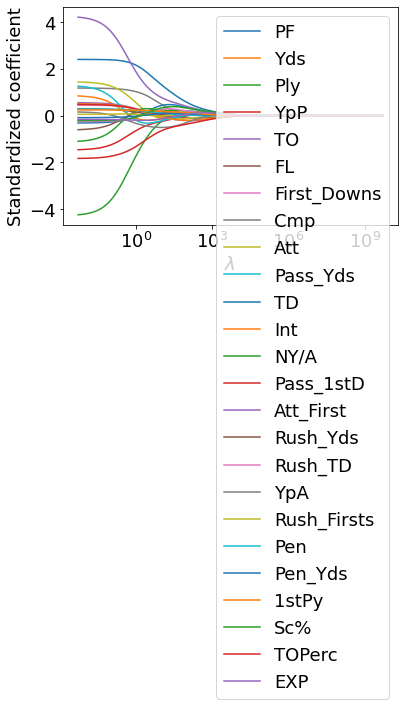

In [163]:
coefs = []
alphas = 10**np.linspace(10,-2,200)*0.5
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)
    
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
legend = plt.legend(train.columns[2:28])

In [105]:
# Optimal Tuning Parameter
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)
ridgecv.alpha_

0.5359456596025638

In [128]:
Xtest = pd.concat([test.iloc[:,26:],test.iloc[:,1:26]], axis=1)
Xtest = Xtest.iloc[:,1:]
Xtest_std = scaler.transform(Xtest)

In [129]:
# Regular Regression Model
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

In [152]:
#RMSE and R-squared
np.sqrt(((pred-test.W)**2).mean())
r2_score(ridge.predict(Xstd),y)

0.6827665937073705

In [145]:
# Forward Stepwise Regression Model
import time
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('W ~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
    
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

X = train[['PF', 'Yds', 'Ply', 'YpP', 'TO', 'FL', 'First_Downs', 'Cmp', 'Att',
       'Pass_Yds', 'TD', 'Int', 'Pass_1stD', 'Att_First', 'Rush_Yds',
       'Rush_TD', 'YpA', 'Rush_Firsts', 'Pen', 'Pen_Yds',
       'TOPerc', 'EXP']]
models_best = forward_selection()

Processed  22 models on 1 predictors in 0.1007390022277832 seconds.
Processed  21 models on 2 predictors in 0.09319519996643066 seconds.
Processed  20 models on 3 predictors in 0.0995631217956543 seconds.
Processed  19 models on 4 predictors in 0.12234091758728027 seconds.
Processed  18 models on 5 predictors in 0.11801290512084961 seconds.
Processed  17 models on 6 predictors in 0.13915419578552246 seconds.
Processed  16 models on 7 predictors in 0.15003299713134766 seconds.
Processed  15 models on 8 predictors in 0.1657400131225586 seconds.
Processed  14 models on 9 predictors in 0.1602611541748047 seconds.
Processed  13 models on 10 predictors in 0.17999482154846191 seconds.
Processed  12 models on 11 predictors in 0.17655706405639648 seconds.
Processed  11 models on 12 predictors in 0.18270182609558105 seconds.
Processed  10 models on 13 predictors in 0.17301106452941895 seconds.
Processed  9 models on 14 predictors in 0.16560983657836914 seconds.
Processed  8 models on 15 predicto

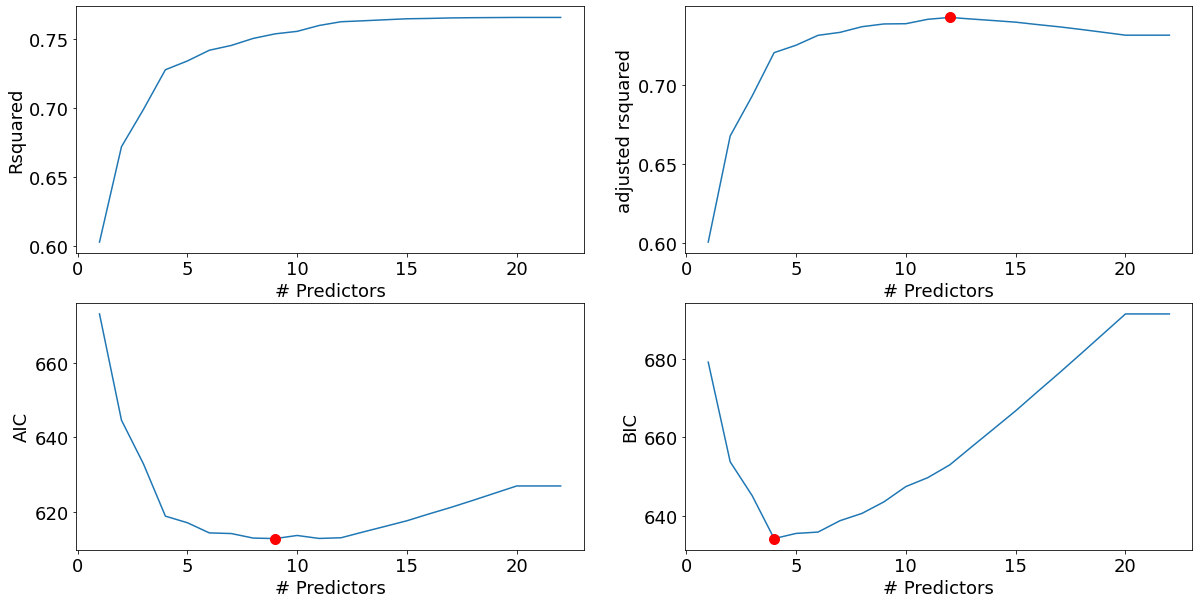

In [146]:
best_sub_plots()
# Use 4 predictors - BIC

In [147]:
best_fwd_reg_model = models_best['model'][4]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     103.4
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           1.02e-42
Time:                        16:23:18   Log-Likelihood:                -304.41
No. Observations:                 160   AIC:                             618.8
Df Residuals:                     155   BIC:                             634.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.3601      1.675     -3.201      0.002      -8.668      -2.052
PF             0.0279      0.002     12.833      0.000       0.024       0.032
TOPerc        -0.2853      0.050     -5.680      0.000      -0.385      -0.186
Att_First      0.0284      0.005      5.529      0.000       0.018       0.039
Rush_Yds      -0.0032      0.001     -4.041      0.000      -0.005      -0.002
==============================================================================
Omnibus:                        3.053   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                2.806
Skew:                          -0.324   Prob(JB):                        0.246
Kurtosis:                       3.046   Cond. No.                     2.53e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[Text(0.5, 0, 'Actual Wins'), Text(0, 0.5, 'Predicted Wins')]

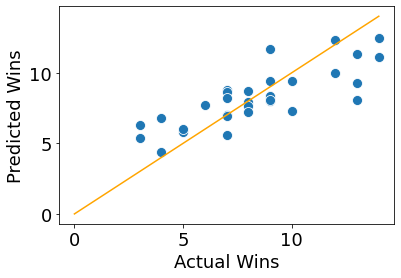

In [166]:
# Prediction
pred_wins = best_fwd_reg_model.predict(test)
gfg = sns.scatterplot(x = test.W, y = pred_wins)
sns.lineplot(x = [0,test.W.max()], y = [0,test.W.max()],color='orange')
gfg.set(xlabel ="Actual Wins", ylabel = "Predicted Wins")

In [171]:
RMSE = np.sqrt(((test.W - pred_wins)**2).mean())
RMSE
(test.W-pred_wins).mean()

0.14364277599928002